<a href="https://colab.research.google.com/github/mtulow/investigate-tornado-weather/blob/main/notebooks/explore_weather_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/mtulow/investigate-tornado-weather/blob/main/notebooks/explore_weather_data.ipynb)

# <center> Tornado Weather Data: Explore Weather Data as it Relates to Tornadoes </center>
---

## Datasets
---

__Relevant Data:__

<center>

|Products|Source|Code|
|:---|:---|---|
|Geographic Boundaries|[NOAA Storm Prediction Center](https://www.spc.noaa.gov/wcm/#data)|[...](#severe-weather-data)|
|Severe Weather: (tornadoes, hail, wind)|[NOAA Storm Prediction Center](https://www.spc.noaa.gov/wcm/#data)|[...](#severe-weather-data)|
|Radar|[NOAA NEXRAD Station Data](https://www.ncdc.noaa.gov/nexradinv/)|[...](#radar)|
|Population|[US Census Bureau](https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html#par_textimage_70769902)|[...](#population)|
|Temperature: (LST, SST)|[NOAA National Centers for Environmental Information](https://www.ncdc.noaa.gov/cdo-web/search)|[...](#temperature)|
<!-- - (https://www.spc.noaa.gov/wcm/#data) -->
</center>

---

## Setup Environment
---

#### Install Packages

In [ ]:
%pip install -q metpy cartopy nexradaws arm_pyart "xarray[complete]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.5/400.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

#### Import Libraries

In [ ]:
import os
import re
import glob
import pytz
import pyart
import folium
import fsspec
import warnings
import requests
import nexradaws
import itertools
import functools
import collections
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

import cartopy.crs as ccrs

import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

warnings.filterwarnings(action='ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Functions
---

---

## Explore Datasets
---

### Geographic Boundaries

###### Downloader Boundary Files

In [ ]:
from fsspec.implementations.zip import ZipFileSystem

def download_geographic_boundaries(geographic_boundary: str, *,
                                   dropna: bool = True, new: bool = False) -> gpd.GeoDataFrame:
    """
    Downloads and reads geographic boundary data from the National Oceanic and Atmospheric Administration (NOAA) Storm Prediction Center (SPC).

    Args:
        geographic_boundary: The name of the geographic boundary to download, e.g., "counties".
        dropna: Whether to drop rows with NaN values. Defaults to True.

    Returns:
        A GeoDataFrame containing the downloaded geographic boundary data.
    """

    url = f'https://www.spc.noaa.gov/gis/svrgis/zipped/{geographic_boundary}.zip'
    filepath = f'data/geographic_boundaries/{geographic_boundary}/{geographic_boundary}.shp'

    if new or not os.path.isfile(filepath):
        print('Downloading...')
        with fsspec.open(url) as of:
            fs = ZipFileSystem(of)
            for item in fs.ls(f'{geographic_boundary}/'):
                src_file = item['filename']
                dst_file = f'data/geographic_boundaries/{src_file}'
                fs.get_file(src_file, dst_file)
        gdf = gpd.read_file(filepath)
    else:
        print('Reading local file...')
        gdf = gpd.read_file(filepath)


    # Optionally drop rows with NaN values
    if dropna:
        gdf.dropna(inplace=True)

    return gdf


#### States

Reading local file...


<Axes: >

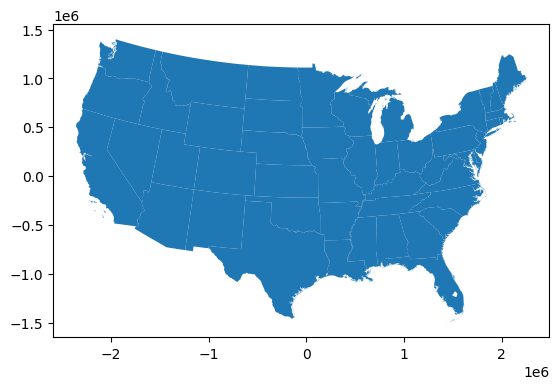

In [ ]:
states = download_geographic_boundaries('states')
states.plot()

#### Counties

In [ ]:
counties = download_geographic_boundaries('counties', False)
counties

Reading local file...


,STATE,CWA,COUNTYNAME,FIPS,TIME_ZONE,FE_AREA,LON,LAT,geometry
0,CA,STO,Yolo,06113,P,cc,-121.95474,38.62376,"POLYGON ((-2235332.572 318267.326, -2222440.98..."
1,CA,STO,Stanislaus,06099,P,cc,-120.92902,37.60600,"POLYGON ((-2144326.549 194328.966, -2142679.90..."
2,AL,HUN,Morgan,01103,C,nc,-86.82820,34.49796,"POLYGON ((841910.511 -447879.462, 842405.349 -..."
3,AL,TAE,Geneva,01061,C,se,-85.83421,31.09921,"POLYGON ((982328.475 -807206.740, 1003828.597 ..."
4,AL,MOB,Escambia,01053,C,sc,-87.15898,31.13412,"POLYGON ((818267.680 -816733.544, 821532.810 -..."
...,...,...,...,...,...,...,...,...,...
3233,NC,GSP,Rutherford,37161,E,ww,-81.98152,35.39209,"POLYGON ((1244636.050 -303785.092, 1243743.117..."
3234,AS,PPG,Manu'a,60020,S,None,-169.46830,-14.24743,None
3235,AS,PPG,Eastern,60010,S,None,-170.64240,-14.27834,None
3236,AS,PPG,Swains Island,60040,S,None,-171.04579,-11.08501,None


#### Cities

In [ ]:
cities = download_geographic_boundaries('cities')
cities

,AREANAME,CLASS,ST,STFIPS,PLACEFIP,HOUSEUNITS,POPULATION,POP_CL,AREALAND,AREAWATER,Shape_Leng,Shape_Area,geometry
0,Birmingham,city,AL,01,07000,111927,242820,8,149.917,2.035,7.200708,0.038229,"MULTIPOLYGON (((-87.06322 33.63846, -87.06305 ..."
1,Bridgeport,city,AL,01,09328,1290,2728,5,3.116,0.129,0.203201,0.000828,"POLYGON ((-85.73787 34.92669, -85.73524 34.928..."
2,Cedar Bluff,town,AL,01,12760,975,1467,4,3.972,0.143,0.390265,0.001053,"POLYGON ((-85.61179 34.22985, -85.61234 34.229..."
3,Centre,city,AL,01,13648,1515,3216,5,10.968,0.106,0.438738,0.002791,"POLYGON ((-85.64992 34.17336, -85.64609 34.173..."
4,Fort Payne,city,AL,01,27616,5585,12938,6,55.876,0.082,0.892492,0.014195,"MULTIPOLYGON (((-85.73215 34.50615, -85.72731 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25143,Westview Circle,CDP,WY,56,82967,25,67,1,2.275,0.042,0.111275,0.000653,"POLYGON ((-105.08290 42.06745, -105.08265 42.0..."
25144,Wheatland,town,WY,56,83040,1764,3548,5,4.236,0.000,0.242371,0.001127,"MULTIPOLYGON (((-104.96308 42.06430, -104.9604..."
25145,Woods Landing-Jelm,CDP,WY,56,84852,86,100,1,16.013,0.000,0.468698,0.004512,"POLYGON ((-106.01381 41.12103, -106.01290 41.1..."
25146,Yoder,town,WY,56,86665,84,169,1,0.204,0.000,0.042719,0.000057,"POLYGON ((-104.29165 41.91948, -104.29083 41.9..."


#### Exploratory Data Analysis - (EDA)

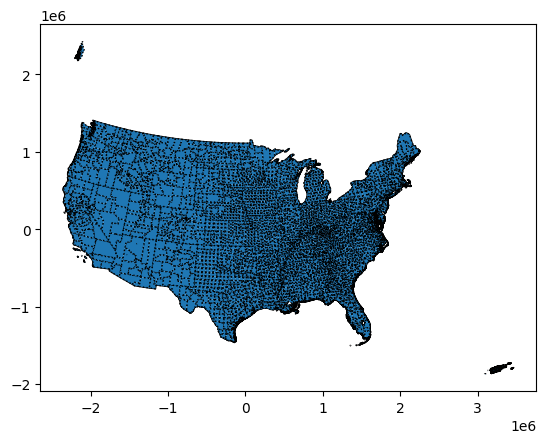

In [ ]:
ax = states.plot(color='whitesmoke', edgecolor='black')
ax = counties.plot(ax=ax, linestyle=':', edgecolor='black')

plt.show()

###### Interactive Maps

In [ ]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [ ]:
def display_interactive_map(*boundary_files):
    def wrapper() -> folium.Map:
        m = folium.Map([39.8098, -98.5551], tiles='cartodbpositron', zoom_start=4)
        return m
    return wrapper

In [ ]:
m = display_interactive_map()
for boundary in [states, counties]:

m

In [ ]:
# m = display_interactive_map()
m = folium.Map([39.8098, -98.5551], tiles='cartodbpositron', zoom_start=4)
m

---

### Severe Weather Data

In [ ]:
def download_severe_weather_data(weather: str, start: dt.datetime, end: dt.datetime, buffer: int = 60, ) -> pd.DataFrame:
    weather = 'torn' if weather == 'tornado'\
        else 'wind' if weather == 'wind'\
        else 'hail' if weather == 'hail'\
        else None

    # Read weather report for year
    weather_rpts = pd.read_csv(f"https://www.spc.noaa.gov/wcm/data/{start.year}_{weather}.csv")

    weather_rpts['datetime'] = pd.to_datetime(weather_rpts.date + ' ' + weather_rpts.time, format='%Y-%m-%d %H:%M:%S') ## convert to datetime
    weather_rpts.set_index("datetime", inplace=True)

    # Times in the file are given in central standard time (UTC+6). Localize, and convert to UTC
    weather_rpts.index = weather_rpts.index.tz_localize("Etc/GMT+6",ambiguous='NaT',nonexistent='shift_forward').tz_convert("UTC")

    # Subset down to a given buffer in minutes before/after the radar times we're plotting
    weather_rpts = weather_rpts[((start-pd.Timedelta(minutes=buffer)).strftime("%Y-%m-%d %H:%M")):\
                                ((end+pd.Timedelta(minutes=buffer)).strftime("%Y-%m-%d %H:%M"))]
    return weather_rpts

In [ ]:
start = pd.Timestamp(2020,8,10,16,30).tz_localize(tz='UTC')
end = pd.Timestamp(2020,8,10,21,0).tz_localize(tz='UTC')

In [ ]:
with fsspec.open('https://www.spc.noaa.gov/gis/svrgis/zipped/cwas.zip') as of:
    fs = ZipFileSystem(of)
    for item in fs.ls('cwas'):
        print(item)

{'orig_filename': 'cwas/cwas.dbf', 'filename': 'cwas/cwas.dbf', 'date_time': (2010, 3, 19, 11, 53, 24), 'compress_type': 8, '_compresslevel': None, 'comment': b'', 'extra': b'UT\x05\x00\x03\xb4e\xa3Kux\x0b\x00\x01\x04/\x01\x00\x00\x04\x14\x00\x00\x00', 'create_system': 3, 'create_version': 30, 'extract_version': 20, 'reserved': 0, 'flag_bits': 0, 'volume': 0, 'internal_attr': 0, 'external_attr': 2175008768, 'header_offset': 63, 'CRC': 2912432299, 'compress_size': 2001, 'file_size': 5742, '_raw_time': 24236, 'name': 'cwas/cwas.dbf', 'size': 5742, 'type': 'file'}
{'orig_filename': 'cwas/cwas.prj', 'filename': 'cwas/cwas.prj', 'date_time': (2010, 3, 19, 11, 53, 24), 'compress_type': 8, '_compresslevel': None, 'comment': b'', 'extra': b'UT\x05\x00\x03\xb4e\xa3Kux\x0b\x00\x01\x04/\x01\x00\x00\x04\x14\x00\x00\x00', 'create_system': 3, 'create_version': 30, 'extract_version': 20, 'reserved': 0, 'flag_bits': 0, 'volume': 0, 'internal_attr': 1, 'external_attr': 2175008768, 'header_offset': 2135

#### Tornadoes

In [ ]:
tornadoes = download_severe_weather_data('tornado', start, end)
tornadoes

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
datetime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 16:30:00+00:00,619402,2020,8,10,2020-08-10,10:30:00,3,IA,19,0,...,1.03,50,1,1,1,127,0,0,0,0
2020-08-10 16:36:00+00:00,619403,2020,8,10,2020-08-10,10:36:00,3,IA,19,0,...,0.42,50,1,1,1,127,0,0,0,0
2020-08-10 16:39:00+00:00,619404,2020,8,10,2020-08-10,10:39:00,3,IA,19,0,...,2.88,100,1,1,1,127,0,0,0,0
2020-08-10 17:01:00+00:00,619405,2020,8,10,2020-08-10,11:01:00,3,IA,19,0,...,1.48,40,1,1,1,171,0,0,0,0
2020-08-10 17:31:00+00:00,619406,2020,8,10,2020-08-10,11:31:00,3,IA,19,0,...,0.92,40,1,1,1,113,0,0,0,0
2020-08-10 17:32:00+00:00,619407,2020,8,10,2020-08-10,11:32:00,3,WI,55,0,...,0.55,50,1,1,1,43,0,0,0,0
2020-08-10 19:12:00+00:00,619408,2020,8,10,2020-08-10,13:12:00,3,IL,17,0,...,4.59,50,1,1,1,177,0,0,0,0
2020-08-10 19:37:00+00:00,619409,2020,8,10,2020-08-10,13:37:00,3,IL,17,0,...,1.58,50,1,1,1,201,0,0,0,0
2020-08-10 19:47:00+00:00,619410,2020,8,10,2020-08-10,13:47:00,3,IL,17,0,...,9.18,300,1,1,1,201,7,0,0,0


In [ ]:
columns = [
    'mag','inj'
]
tornadoes = tornadoes
tornadoes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 2020-08-10 16:30:00+00:00 to 2020-08-10 21:15:00+00:00
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   om      26 non-null     int64  
 1   yr      26 non-null     int64  
 2   mo      26 non-null     int64  
 3   dy      26 non-null     int64  
 4   date    26 non-null     object 
 5   time    26 non-null     object 
 6   tz      26 non-null     int64  
 7   st      26 non-null     object 
 8   stf     26 non-null     int64  
 9   stn     26 non-null     int64  
 10  mag     26 non-null     int64  
 11  inj     26 non-null     int64  
 12  fat     26 non-null     int64  
 13  loss    26 non-null     int64  
 14  closs   26 non-null     int64  
 15  slat    26 non-null     float64
 16  slon    26 non-null     float64
 17  elat    26 non-null     float64
 18  elon    26 non-null     float64
 19  len     26 non-null     float64
 20  wid     26 non-null     int6

#### Hail

In [ ]:
hail = download_severe_weather_data('hail', start, end)
hail

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,elon,len,wid,ns,sn,sg,f1,f2,f3,f4
datetime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 18:25:00+00:00,656603,2020,8,10,2020-08-10,12:25:00,3,IA,19,0,...,-90.9900,0,0,0,0,0,61,0,0,0
2020-08-10 18:35:00+00:00,656604,2020,8,10,2020-08-10,12:35:00,3,IL,17,0,...,-89.6200,0,0,0,0,0,177,0,0,0
2020-08-10 19:45:00+00:00,656605,2020,8,10,2020-08-10,13:45:00,3,MI,26,0,...,-87.6100,0,0,0,0,0,109,0,0,0
2020-08-10 19:53:00+00:00,656606,2020,8,10,2020-08-10,13:53:00,3,IL,17,0,...,-88.9800,0,0,0,0,0,201,0,0,0
2020-08-10 20:00:00+00:00,656607,2020,8,10,2020-08-10,14:00:00,3,IL,17,0,...,-88.8600,0,0,0,0,0,7,0,0,0
2020-08-10 20:27:00+00:00,656608,2020,8,10,2020-08-10,14:27:00,3,IL,17,0,...,-88.4200,0,0,0,0,0,63,0,0,0
2020-08-10 20:29:00+00:00,656609,2020,8,10,2020-08-10,14:29:00,3,IL,17,0,...,-88.4328,0,0,0,0,0,63,0,0,0
2020-08-10 20:30:00+00:00,656610,2020,8,10,2020-08-10,14:30:00,3,IL,17,0,...,-88.3500,0,0,0,0,0,93,0,0,0
2020-08-10 20:43:00+00:00,656611,2020,8,10,2020-08-10,14:43:00,3,IL,17,0,...,-88.0527,0,0,0,0,0,43,0,0,0


#### Wind

In [ ]:
wind = download_severe_weather_data('wind', start, end)
wind

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,mt
datetime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 15:30:00+00:00,693915,2020,8,10,2020-08-10,09:30:00,3,IA,19,0,...,0,0,0,0,0,73,0,0,0,EG
2020-08-10 15:32:00+00:00,693916,2020,8,10,2020-08-10,09:32:00,3,IA,19,0,...,0,0,0,0,0,49,0,0,0,EG
2020-08-10 15:32:00+00:00,693917,2020,8,10,2020-08-10,09:32:00,3,IA,19,0,...,0,0,0,0,0,49,0,0,0,EG
2020-08-10 15:33:00+00:00,693918,2020,8,10,2020-08-10,09:33:00,3,IA,19,0,...,0,0,0,0,0,49,0,0,0,EG
2020-08-10 15:37:00+00:00,693919,2020,8,10,2020-08-10,09:37:00,3,IA,19,0,...,0,0,0,0,0,49,0,0,0,EG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10 21:55:00+00:00,694367,2020,8,10,2020-08-10,15:55:00,3,KS,20,0,...,0,0,0,0,0,21,0,0,0,EG
2020-08-10 22:00:00+00:00,694368,2020,8,10,2020-08-10,16:00:00,3,MI,26,0,...,0,0,0,0,0,7,0,0,0,EG
2020-08-10 22:00:00+00:00,694369,2020,8,10,2020-08-10,16:00:00,3,IN,18,0,...,0,0,0,0,0,165,0,0,0,EG


###### Exploratory Data Analysis - (EDA)

In [ ]:
tornadoes.columns

Index(['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4', 'fc'],
      dtype='object')

In [ ]:
tornadoes[['slat','slon','elat','elon']]
starting_pts = gpd.GeoDataFrame(tornadoes[[]])

,slat,slon,elat,elon
datetime,,,,
2020-08-10 16:30:00+00:00,42.0016,-93.0701,41.9977,-93.0508
2020-08-10 16:36:00+00:00,42.1250,-93.0684,42.1223,-93.0609
2020-08-10 16:39:00+00:00,42.0907,-92.9778,42.0790,-92.9238
2020-08-10 17:01:00+00:00,42.1598,-92.6208,42.1450,-92.5999
2020-08-10 17:31:00+00:00,41.9063,-91.7290,41.9030,-91.7121
2020-08-10 17:32:00+00:00,42.6940,-90.8312,42.6947,-90.8204
2020-08-10 19:12:00+00:00,42.2119,-89.6884,42.2697,-89.6446
2020-08-10 19:37:00+00:00,42.2495,-89.1332,42.2620,-89.1073
2020-08-10 19:47:00+00:00,42.2806,-89.0220,42.3692,-88.8891


---

### Weather Radar

###### via `s3fs` for Amazon S3

###### via `gcsfs` for Google Cloud Storage

###### via `adlfs` for Azure DataLake storage

---

### Population

---

### Temperature

---
---

## Setup Data
---

## Visualizations
---